# Chunking Guidance for Retireval Augmentation Generation 

Retrieval Augementation and Generation (RAG) systems are increasingly popular as a way to bootstrap an LLM on your own information. 

It is easy to implement a proof of concept that passes the infamous "vibe" check fairly quickly - Particularly using a framework that abstracts a lot of the detail. This might get an engineer 70-80% of the way, but as with any data driven system, the devil really is in the details when it comes to squeezing out the extra performance that gives end users confidence.

Through this notebook we'll look at how to best understand a corpus of documents, some analysis that can help determine some of the parameters of your chunking, and how to go about running experiments to see what really works for your data. We'll run the baseline experiment "from first principles" i.e. where it makes sense we won't use any fancy tooling that abstracts what's going on under the hood. For subsequent experiments, we'll use separate notebooks and show how some popular tooling can make life a lot easier!

Chunking stratey is one of many factors that contribute to the success (or failure!) of a RAG system. We'll touch on other areas like retrieval, generation and evaluation, but we won't deep dive on everything here.

## Purpose

### What it is

This notebook aims to give direction to software engineers in how they might approach evaluating, and selecting a chunking methodology for a RAG system. It is not meant to be an accelerator or template. There are other great resources for that like the [RAG Experiment Accelerator](https://github.com/microsoft/rag-experiment-accelerator). Instead this is meant to be complementary to those assets, highlight the thinking and decisions that you might make whilst approaching a chunking problem. If there's one thing we'd like you to take away from this notebook, it's that every step represents a decision that impacts the performance of your application.

### What it is not

This notebook does NOT intend on covering end to end evaluation of RAG systems, as that is a much broader topic that dives into information retrieval. Resources for tuning those elements of a RAG system can be found [here](). Nor is it intended as a template for production deployments.


## Outline

1. [Exploring your data](#exploring-your-data)
2. [Chunks, Words, Tokens and Contexts](#chunks-words-token-and-contexts)
3. [Experiment Setup](#experiment-setup)
4. [Building an Evaluation Dataset](#building-an-evaluation-dataset)
5. [RAGE-1: RAG Experiment Harness](#rage-1-rag-experiment-harness)
6. [RAGE-2: RAG Evaluation Harness](#rage-2-rag-evaluation-harness)

Let's get started!

## Loading a Corpus

First things first, let's load some text data to work with. Let's go with the [pubmed summarisation dataset](https://huggingface.co/datasets/ccdv/pubmed-summarization). 

> NOTE: In practice, it's unlikely that you'll receive data that is in a uniform format that's easy to work with - it may require pre-processing steps.

We'll download from hugging face, but for simplicity we'll convert the dataset to pandas, which most data pro's are familiar with. This step will need to download ~3.5GB of data the first time you run it, but will be stored and the load step much faster fo subsequent runs.

> NOTE: In practice, your data may be too large to load into a pandas dataframe. There are a number of best practices around this, consult your local data scientist/engineer for the best approach for your use case.

> KEY TAKEAWAY: This repository will help you understand and the decisions that can be made when evaluating chunking strategies, and how to measure their impact

In [2]:
# Imports

from datasets import load_dataset
from uuid import uuid4
from pprint import pprint
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tiktoken as tk
import random
import json
from multiprocessing import Pool

# Set to pubmed or arxiv
publication = 'pubmed'

dataset = load_dataset(f'scientific_papers',publication,split='train', trust_remote_code=True)

# Convert to a pandas dataframe and do some housekeeping
ds = dataset.to_pandas()
ds['doc_id'] = [str(uuid4()) for _ in range(len(ds))]
ds['article_len'] = ds['article'].apply(lambda x: len(x.split()))

ds.drop(columns=['abstract'],inplace=True)

# Take a look at our data
display(ds.head())

article  \
0  a recent systematic analysis showed that in 20...   
1  it occurs in more than 50% of patients and may...   
2  tardive dystonia ( td ) , a rarer side effect ...   
3  lepidoptera include agricultural pests that , ...   
4  syncope is caused by transient diffuse cerebra...   

                                       section_names  \
0  INTRODUCTION\nMATERIALS AND METHODS\nParticipa...   
1  Introduction\nPatients and methods\nStudy desi...   
2  INTRODUCTION\nCASE REPORT\nDISCUSSION\nDeclara...   
3  1. Introduction\n2. Insect Immunity\n3. Signal...   
4  Introduction\nCase report\nDiscussion\nConflic...   

                                 doc_id  article_len  
0  ecd83267-b4fb-483b-8235-6beb7d3e31db         4811  
1  3969d61a-8e19-4c32-9531-841ae23f58a9         3258  
2  0a649f0c-e310-4451-b3af-2d552cbd8004         1260  
3  abcde11b-6ae7-4c4a-ab6b-b65e9e5c8925         6465  
4  477d46e0-ca45-4425-925f-7ac2881a2f71         1140

## Exploring your data

One of the main things that we are concerned with when building RAG systems is the length of the data that we intend to feed in to an LLM. Even with context windows becoming increasingly large, we still don't really know if simply throwing more data at an LLM is effective, and it is definitely not quick. In general it's a good idea to have a solid understanding of the data you'll be working with and consider non functionals like performance and cost up front.

> KEY TAKEAWAY: Whilst bigger models are capable, often a smaller model with better curated data will perform just as well, cost less, and result in a more responsive application.

Let's start by understanding how long a typical article is, and get a feel for the boundaries and overall distribution of our data.

An easy way to do this is to look at some basic stats, and draw a histogram.

article_len
count  119924.000000
mean     3043.130683
std      2455.266032
min         0.000000
25%      1463.000000
50%      2571.000000
75%      3995.000000
max    109759.000000

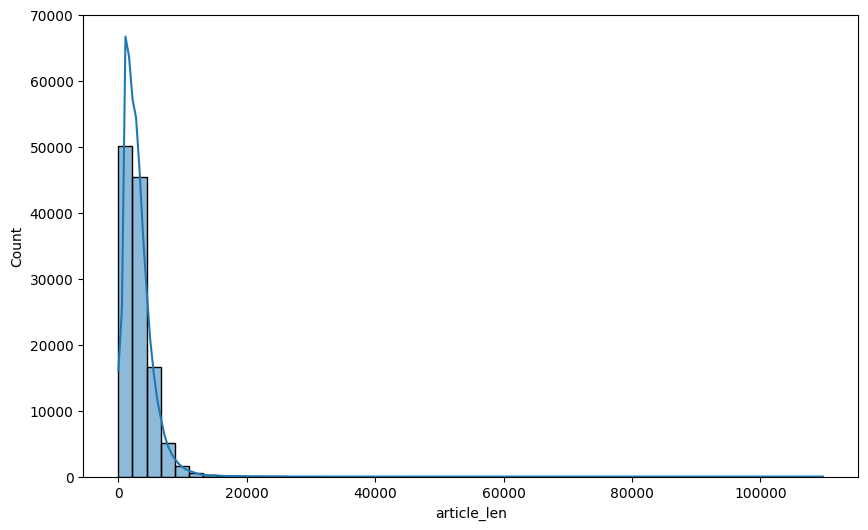

In [3]:
display(ds.describe())

fig = plt.figure(figsize=(10, 6))
sns.histplot(ds['article_len'], bins=50, kde=True)
plt.show()

Both the table and the diagram show what's called a heavy right skew - meaning that there are a small number of extremely large values. 

What we do with these extra long articles is an important decision. For some data problems you'd look to exclude outliers. But given this is an information retrieval problem, we'd like to keep as much data as possible. 

What we need to do, is understand  *why* some of these articles are so long, and deal with them accordingly

First, lets zoom in on the distribution and if we can find a more reasonable cut off point.

> KEY TAKEAWAY: There will almost always be outliers in a dataset. It is important to understand why they are different, and how you handle them depends on your use case!

In [4]:
ds.describe(percentiles=[0.75,0.8, 0.9,0.95, 0.99])

article_len
count  119924.000000
mean     3043.130683
std      2455.266032
min         0.000000
50%      2571.000000
75%      3995.000000
80%      4418.000000
90%      5739.000000
95%      7057.000000
99%     10644.770000
max    109759.000000

The problem is definitely in the high end of town, with a jump from 10k to 112k in number of words for the last percentile. Let's take a closer look at the raw data and see if we can tell what's going on.

In [5]:
# Get the indices of the articles with the longest length
longest_articles = ds['article_len'].nlargest(5).index
for idx in longest_articles:
    print(f'Article Length: {ds["article_len"][idx]}\n')
    print(ds['article'][idx]+'\n')
    print('\n')

Article Length: 109759

the search for a physically viable theory of quantized gravitation is ongoing ; in part because the physics it ought to describe is unknown , and in part because different approaches may not 
the most prominent contenders are string theory and loop quantum gravity , with ample literature available on either sides . for book - sized expositions
the present report and   describe a circle of ideas which differ in several important ways from these approaches .
first , the gravitational field itself is taken seriously as the prime carrier of the relevant classical and quantum degrees of freedom .
second , a physics premise (  antiscreening  ) is made about the self - interaction of these quantum degrees of freedom in the ultraviolet .
third , the effective diminution of the relevant degrees of freedom in the ultraviolet ( on which morally speaking all approaches agree ) is interpreted as universality in the statistical physics sense in the vicinity of an ultraviolet 

At first glance, it appears that the two main causes of long documents are either:
- LaTeX package inclusions (mathematical formatting for scientific documents)
- Data tables (from pharmaceutical research by the look of it)

In practice we would want to spend more time understanding the drivers behind the outliers, and address as many as possible. However, for the purposes of this exercise we will focus on the LaTeX issue. 

Data tables could be solved through an application of difference pdf cracking techniques (e.g. [Azure Document Intelligence](https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augmented-generation?view=doc-intel-4.0.0)), but that is out of scope for this notebook.

Let's remove the the lines which include LaTeX and take another look at the adjusted distributions.

In [6]:
from helper.general import remove_latex_packages

# Remove LaTeX package inclusions from the articles
ds['article'] = ds['article'].apply(remove_latex_packages)

# Recalculate article lengths
ds['article_len'] = ds['article'].apply(lambda x: len(x.split()))

display(ds.describe(percentiles=[0.75,0.8, 0.9,0.95, 0.99]))

article_len
count  119924.000000
mean     3038.964944
std      2410.056920
min         0.000000
50%      2570.000000
75%      3994.000000
80%      4417.000000
90%      5737.000000
95%      7048.000000
99%     10608.310000
max     94877.000000

This has made a difference, but 95k is still very large. For now, let's exclude the longer documents, storing them in another dataframe for analysis later.

Once we remove the odd docs, we'll check our distribution again to make sure that we now have something workable.

> KEY TAKEAWAY: When removing outliers, or error records, it's important not to discard them. Store them somewhere to be reviewed at a later date.

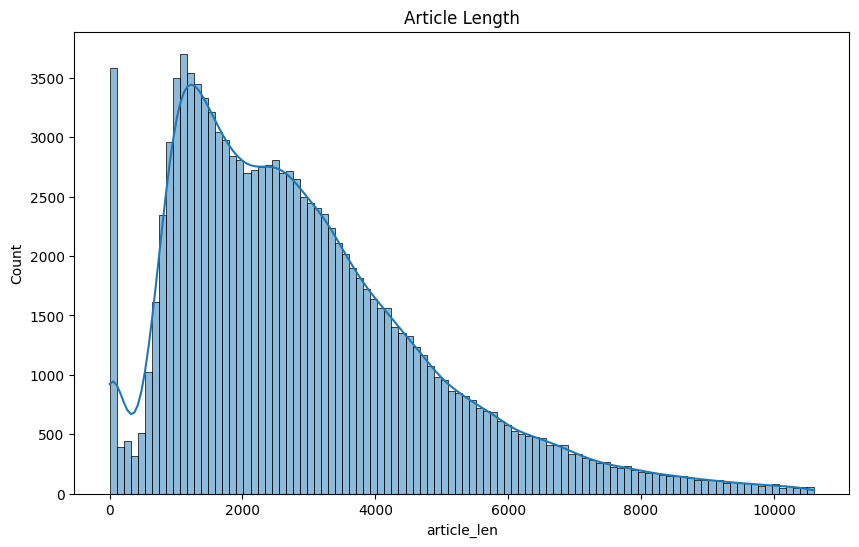

article_len
count  118724.000000
mean     2918.005492
std      1925.843736
min         0.000000
25%      1452.000000
50%      2547.000000
75%      3935.000000
max     10606.000000

In [7]:
from helper.general import remove_over_percentile

#apply helper function from utils module
ds_99pct, ds_outliers = remove_over_percentile(ds, 'article_len', .99)

fig = plt.figure(figsize=(10, 6))

# Plot the first histogram on the first subplot
sns.histplot(ds_99pct['article_len'], bins=100, kde=True)
plt.title('Article Length')


# Display the plots
plt.show()

display(ds_99pct.describe())

Let's take a quick look at the smallest articles too. The above histogram indicates that there are a number of articles that have length of less than 500 words. Let's check formally and then take a peek.

In [8]:
count_tiny_articles = ds_99pct['article_len'][ds_99pct['article_len'] < 500].count()

print(f'Number of articles with less than 500 words: {count_tiny_articles}')

smallest_articles = ds_99pct['article_len'].nsmallest(count_tiny_articles).index
for idx in smallest_articles:
    print(f'Article Length: {ds_99pct["article_len"][idx]}\n')
    print(ds_99pct['article'][idx]+'\n')
    print('\n')

Number of articles with less than 500 words: 5046
Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article Length: 0





Article

Scanning through the articles there are some empty records, but the majority seem to be fractions of documents rather than complete articles. In this specidic case, we can reasonably conclude that these are invalid records and exclude them from our system. It's worth calling out that this exclusion is different from excluding the large ones, as they are malformed at source and there is little that we can do to remediate without calling a friend! 

>NOTE: In practice, we would go back to the customer and review these records to decided whether it's appropriate to keep them or not.

In [9]:
ds_clean = ds_99pct[ds_99pct['article_len'] >= 500]

Now that we have our cleansed dataset, let's start talking about tokens, why it's good to know about them, and how they relate to designing a RAG system.

## Chunks, Words, Token and Contexts

Despite feeling like LLMs converse in our language, there's a few things that go in behind the scenes that translate our verbiage into something an algorithm understands. 

Firstly, the text is `tokenized`, which means words are split into a list of `tokens`. Think of this a bit like stemming in NLP. For shorter words, the ratio of tokens to words can be 1:1 (i.e. the word = the token), but for longer, or more complex words the ratio can be far higher. 

These lists are then mapped into numerical vectors that the algorithm can understand. For a given corpus, we could work out the exact ratio - in fact, let's do that!

(for a visual explanation of tokens see [this](https://www.tokencounter.io/) excellent resource)

First we will apply the appropriate encoding to the text, then we simply sum up the number of tokens and words in the corpus and calculate the number of tokens / word.

> KEY TAKEAWAY: Tokens are the currency of LLMs - they're how we measure inputs and outputs and often what pricing and API limits are based on. 

In [10]:
# run the tokeniser over the articles and store the results in the DataFrame
# Given the size of the dataet this can take up to 10 minutes Let's select a 
# random sample of 5000 articles to reduce the time down to ~ 10 seconds
# Feel free to grab a beverage and run the analsis on the entire dataset to
# compare the results if you have the time!

subset = True

if subset == True:
    random.seed(42)
    random_doc_ids = random.sample(list(ds_clean['doc_id'].unique()), 5000)

    # Subset the DataFrames
    ds_clean = ds_clean[ds_clean['doc_id'].isin(random_doc_ids)]

encoding = tk.encoding_for_model('gpt-3.5-turbo')

article_tokens = ds_clean['article'].apply(encoding.encode)

# check if columns already exist
if 'article_tokens' in ds_clean.columns:
    ds_token_count_subset = ds_clean.drop(columns=['article_tokens'])

ds_clean = ds_clean.assign(article_tokens=article_tokens)
ds_clean['article_tk_len'] = ds_clean['article_tokens'].apply(lambda x: len(x))
ds_clean['token_ratio'] = ds_clean['article_tk_len']/ds_clean['article_len']

total_words = ds_clean['article_len'].sum()
total_tokens = ds_clean['article_tk_len'].sum()

ratio = total_tokens/total_words

print(f'The ratio of tokens to words is {ratio:.2f}')
print(f"The largest article has {ds_clean['article_tk_len'].max()} tokens")
print(f"The smallest article has {ds_clean['article_tk_len'].min()} tokens")
print(f"The mean number of tokens is : {ds_clean['article_tk_len'].mean()}")

The ratio of tokens to words is 1.26
The largest article has 24684 tokens
The smallest article has 595 tokens
The mean number of tokens is : 3817.727


Now we know the overall ratio we can make some assumptions around cost and how much information we feed the generation step as context.

Before we move on, let's just take a look at the distribution of ratios - some articles might use more complex language than others. Whilst this ratio is not directly useful, it could be a red flag that some data is being excluded. You may look at doing outlier analysis to dive deeper into how your encoder is functioning, and is not excluding words that are specific to the domain, and whether or not your embedding model is appropriate for the use case. We need to make sure this step is correct as it's our last touch point with the LLM.

For this we'll use a violin plot which is similar to a box plot, but with more flexibility.

The plot below shows that we have a few articles that have high token ratios - an interesting problem for another time!

> KEY TAKEAWAY: Derived stats like token ratios can be useful in spotting outliers in your data, or areas where your encoding model is not functioning as you expect.

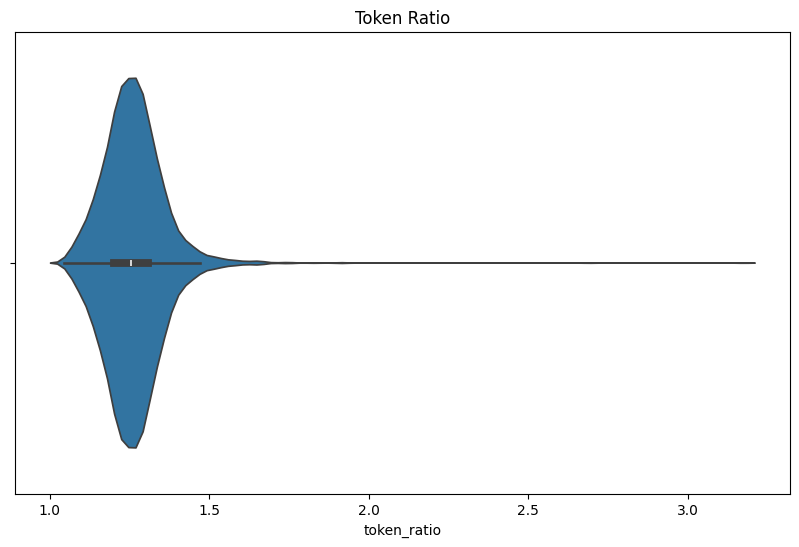

In [11]:
# create a violin plot of token ratios
fig = plt.figure(figsize=(10, 6))
sns.violinplot(x='token_ratio', data=ds_clean)
plt.title('Token Ratio')
plt.show()

### Why do we care about this?

How many records do we want to include in our Augmentation step when constructing the generation prompt? Say we're using GPT-35-Turbo, we have aprx 4000 tokens to play with. This is both **input and output**.

Let's assume the following:

1. We have a prompt template which is a total of 500 tokens, including our guardrails, instructions and any other boiler plate commentary that needs to be input to the generation step.
2. We allow for up to 500 tokens in a response. 

$$Guardrails + Instructions + Estimated Response Length + Retrieved Context < Model Token Limit$$


Meaning with **GPT-35-Turbo**:
$$ 500 + 500 + Retrieved Context < 4000 $$

or $ Retrieved Context < 3000 $

This leaves us with 3000 tokens to play with. If we assume a chunk size  of 500, that gives us 6 records in our retrieval step. In fact, this might be a good starting point. It glosses over whether or not 500 tokens is enough to capture something that is semantically relevant and (more importantly!) useful for the generation step, but we'll take a look at that as we experiment with different chunking strategies.

Now we have some idea of a driving non functional contraint. Let's talk about what makes a good chunk.

> KEY TAKEAWAY: By understanding token counts, we can estimate and budget for what we're going to send to an LLM in the generation step.

### What makes a good chunk?

Let's start by really addressing what a chunk is intended to do. It's sole purpose is to provide context to a model that enhances the available "knowledge" available to the LLM to better answer a given question.

To do that well, a chunk should:

1. Be relevant to the query or task
2. Be factually accurate and avoid misleading information
3. Be specific - focused information rather than overly broad content
4. Concise and information dense. Conveying information effectively within a limited space
5. Referenceable. A user should always be able to go back and see the chunk in context of it's parent document

Let's talk about each in turn:

#### Relevance

This is primarily the focus of optimising search results. What metrics do you choose to select you chunks when executing the retrieval step. [Cosine Similarity]() and the [dot product]() are two commonly used metrics. You may expand this by performing a hybrid search (adding metadata to your quesry - for example published dates, authors etc.), or even looking at strategies for [re-ranking](). The specifics of these techniques are beyond the scope of this notebook as they fall into a separate, and expansive discipline (Maybe another notebook!). In our example we are simply taking the top n records based on cosine similarity.

#### Factual Accuracy

This is fundamentally a data governance problem. Where did your data come from, is it up to date, can you trust the source. An example provided in a recent epiisode of [Practical AI]() gave the example of an HR bot being queried on annual leave policies. One data source could be the official HR policy which contains relevant, up to date information, whereas another source could be chat logs that are dated and included discussions from other georgaphies that aren't relevant to the users context. In our example, we are essentially outsourcing the governance problem by trusting the Hugging Face dataset and PubMed as sources.

#### Specificity

This is where our chunking strategy starts to play a part. How many topics does a chunk cover? Is it general in nature, or does it cut to the point. It may be that we find that chunk length correlates well with specificity. Perhaps we need ot look at topics, or semantic consistency in chunks. More on all of this to come! Increased specificity doesn't always equate to better performance, for example what if users ask general, conversational questions... do they always expect a scientific and targetted response? Probably not.

#### Concise

We've illustrated the finite number of tokens we have to play with in the previous section. We ideally want information dense chunks that provide the correct context without rambling and consuming too many tokens.

#### Referencable

Whilst the ultimate answer is generated by an LLM, often users will want to check the source. It is best practice to provide both the context, and the source of the context items back to the user for verification and / or further research. We'll achieve this by making use of metadata in our vector index.

Now we understand our data, how we need to manage the inputs to a RAG system, and what a good output looks like. Let's set up our experiments.

> KEY TAKEAWAY: A solid chunking strategy will consider chunks across the following dimensions: relevance, factual accuracy, specificity, conciseness, and referencability

## Experiment Setup

At Microsoft, we use a framework called the [AI Garden](https://github.com/cse-labs/ai-garden/tree/main). This allows us to group related experiments into "experiment families" and collaborate across groups and engagements in sharing knowledge and learnings.

In this repo we have the [experiments](experiments) directory which contains our experiment family and distinct experiment plans and results. We also include Architectural Decision Records (ADRs) which include important technical decisions that impact the outcome, along with reasoning. I encourage you to check these out! 

> KEY TAKEAWAY: How we conduct, execute and log our experiments is important. Done well, this will allow others to understand and build on our work.

### Subset data

Given this is an illustration of the process and thinking, now that we have a clean dataset we're going to go one step further an subset the data down to 50 randomly selected articles - mostly because I'm terrified of my GPT4 bill! 

To stress this point, we'll assume from here on in that the subset is whole of the corpus. 

> NOTE: In practice, to test your retrival steps you would need to generate representative evaluation data from the entire corpus, and run retrieval against it.

In [12]:
# select a random 50 unique doc_ids and subset ds_cleam - note we will use this again later!
random.seed(42)
random_doc_ids = random.sample(list(ds_clean['doc_id'].unique()), 50)

# Subset the DataFrames
ds_subset = ds_clean[ds_clean['doc_id'].isin(random_doc_ids)]

#write out the dataset to a csv file
ds_subset.to_csv('data/ds_subset.csv', index=False)

### Building an Evaluation Dataset

Now that we have the data, let's think about how we are going to evaluate our chunking strategies. The evaluation metrics are outlined in the [experiment documentation](./experiments/00-chunking-strategies-family.md). The foundation of evaluation is a good set of question / answer pairs.

Why do we do this?

#### Simulating Real-World Use:

- QA pairs mimic how users interact with a RAG system. Users ask questions, and the system retrieves documents and generates answers based on those documents.
- By testing with good QA pairs, you ensure the RAG system performs well in scenarios it's designed for.

#### Evaluating Retrieval Accuracy:

- Good QA pairs often have answers that can be found within a relevant document. This allows you to see if the RAG system retrieves the documents that actually hold the answer.
- Poor retrieval throws off the entire RAG process, so evaluating retrieval accuracy is crucial.

#### Assessing Answer Quality:

- QA pairs with well-defined answers provide a benchmark for the RAG system's generation capabilities
- You can compare the generated answer to the actual answer in the retrieved document to see if the RAG system effectively uses the information.

#### Identifying System Biases:

- A diverse set of QA pairs helps identify potential biases in the RAG system.
- For instance, if the system struggles with specific question types or topics, the QA pairs will reveal these weaknesses.

#### Not just any QA pairs will do:

- Good QA pairs should be well-formed, grammatically correct, and cover a range of difficulty levels and topics relevant to your RAG system's intended use.
- In essence, good QA pairs provide a realistic testing ground to assess how well your RAG system retrieves information and generates accurate and relevant answers.

Now, I don't have the time or expertise to generate a set of Q&A for these pubmed articles. A popular (but flawed!) approach is to use a leading LLM to read the documents and create the question answer pairs for you. This would be reviewed, and augmented by a selection of subject matter experts before being used as a the basis for measurement. There are a number of problems with using this approach in the real world - as LLms tend to generate simple "factual questions". I can't stress enough the importance of having human subject matter experts supply, or at least review and augment this evaluation dataset to ensure it's representative of the target user intent. We see this all over the place in LLM leaderboads using datasets like [SQUAD]().

If you're interested in how to generate a good ground truth dataset - let the team know and we'll work on writing some guidance.

To do this, we will create a prompt template that submits each article, and generates a set of 5 question answer pairs in a specific format. Once we have the template, we can submit the prompts to our model of choice. 

Using GPT4 this should take about 5 minutes.

> NOTE: Given this requires a structured output, we recommend using gpt-4 for this step. There are other ways to apply structure to outputs, but for simplicity's sake we'll use a the sledgehammer.

> KEY TAKEAWAY: How you construct your evaluation dataset matters. Generating synthetic data is useful to bootstrap, but to have confidence in a production system, real user / SME feedback is required for the Q&A evaluation data.

In [17]:
from helper.openai_utils import general_prompt, create_client
from helper.general import convert_to_dict
from rag.data_prep import generate_qa_prompt

# Create an OpenAI client
oai_client = create_client()
model = os.getenv("QA_MODEL")

def _process_article(article):
    return general_prompt(oai_client, generate_qa_prompt(article), model=model)


def create_qa_pairs(client, model, articles, save_output=True, parallel=True):
    if parallel is True:
        with Pool() as pool:
            results = pool.map(_process_article, articles)

    else:
        prompts = [generate_qa_prompt(article) for article in ds_subset["article"]]
        results = [general_prompt(client, prompt, model=model) for prompt in prompts]

    # Save the results to a file
    qa_pairs = convert_to_dict(results)
      
    questions = [pair["question"] for pair in qa_pairs]
    answers = [pair["answer"] for pair in qa_pairs]

    # Create a DataFrame with the questions and answers
    qa_df = pd.DataFrame({"question": questions, "ground_truth": answers})

    if save_output is True:
        qa_df.to_csv('data/qa_pairs.csv', index=False)
        
    return qa_df

# if the data is already saved, load it
if os.path.exists('data/qa_pairs.csv'):
    qa_df = pd.read_csv('data/qa_pairs.csv')
else:
    qa_df = create_qa_pairs(oai_client, model, ds_subset["article"], save_output=True, parallel=True)

## RAGE-1: RAG Experiment Harness

### Setting up the Experiment

What do we need to do next. Given a dataframe containing our chunked documents we must:

- Chunk the documents
- Embed the chunks.
- Store it in a vector database.
- Query the db using our ground truth (GT) question answer pairs.
- Create a generation prompt which includes the question, and the retrieved "context".
- Run the generation prompt and store the Question, Answer, GT Answer, Context for our evaluation framework.

Let's follow our [baseline experiment](experiments/01-chunking-strategies-baseline.md) as an example. 

In [19]:
experiment_name = "baseline_pubmed_articles"
evaluation_data = qa_df
input_data = ds_subset

#### Chunking the documents

Based on our earlier analysis, let's take a chunk size of 400 words with an overlap of 50. We can calculate the exact length of requests later, but 400 words is approximately 500 tokens per chunk based on our analysis and we should be able to fit multiple results into our context.

In [20]:
from rag.chunking import chunk_string_with_overlap

# Create a new DataFrame with each chunk as a separate row
chunks = []
doc_ids = []
chunk_ids = []
for idx, row in input_data.iterrows():
    article_chunks = chunk_string_with_overlap(input_text=row['article'], chunk_length=400, overlap=50)
    chunks.extend(article_chunks)
    doc_ids.extend([row['doc_id']] * len(article_chunks))
    chunk_ids.extend([f"{row['doc_id']}-{i+1}" for i in range(len(article_chunks))])

ds_chunked = pd.DataFrame({'doc_id': doc_ids, 'chunk_id': chunk_ids, 'chunks': chunks})
ds_chunked.to_csv('data/ds_chunked.csv', index=False)


Let's take a look at some of our chunks - it helps to do a sense check as if we see something wrong, it's a lot easier to fix now than after creating your embeddings and search indexes.

In [21]:
# display a random sample of the chunked data show the full string
for chunk in ds_chunked['chunks'].sample(5):
    print(chunk)
    print('\n') 

system is the main synchronizer of biologic rhythms of the body , effecting their coordination . defects in the activity of this system ( abnormal melatonin production and/or shift of its secretion phase ) result in desynchronization of body biorhythms and the development of various pathologies . an inverse pineal gland relationship with scn plays a major role here , as its disturbance changes periods of internal pacemaker activity , thus leading to desynchronization and impairment of related body processes . in the case of pineal gland / scn system dysfunction , disorders of the hypothalamopituitary - adrenal axis are observed , particularly in the secretion of cortisol and other mineral corticoids , and the osteoblast function [ 3032 ] . this results in multiple disruptions of various functional body systems . in vertebrate animals , somatotropic hormone ( sth ) , or growth hormone , of the anterior lobe of the hypophysis is the main regulator of protein synthesis , which also affect

Already we can see that sentences are broken, and that perhaps this isn't a great way of splitting our information. That being said we are generating a baseline and we expect the subsequent experiments to offer significant uplift. For now let's proceed.

> KEY TAKEAWAY: Even before we've run expensive and time consuming API calls, we can see that the results are not ideal. It's often worth iterating on this before investing time and money in the more nuanced tuning approaches.

#### Embed the chunks

We will use the `ada-v2` embedding model for this example as it is fairly powerful and well understood. It's worth noting that this will not always be the best model, paticularly when data contains topics and content that relate to finding outside of the embedding model's training data. Fine tuning an embedding model on a specific corpus (particularly in the case of highly specialised data) is also a popular option.

Most vector databases implement a wrapper around common embedding functions. Here we will configure and use the wrapper for openai embeddings in ChromaDB. This function is used to embed all documents in a collection, and also to embed queries as they come in.

In creating the index, we also need to specify the measurement method. For illustratice purposes we've used cosine similarity. In reality, for enterprise use cases index design is a rich topic in itself. Again, call out if you'd like more content on index design and choice of search engine! 

> KEY TAKEAWAY: Your choice of embedding model matters! It should be consistent across your index. and should be relevant to your data.


In [22]:
import chromadb.utils.embedding_functions as embedding_functions
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())   
# Specify Embedding model
embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")

# Used in chromadb to embed docs and queries
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                api_base=os.getenv("AZURE_OPENAI_ENDPOINT"),
                api_type="azure",
                api_version=os.getenv("OPENAI_API_VERSION"),
                model_name=embedding_model
            )
# Create a new collection in ChromaDB

from chromadb import PersistentClient

chroma_client = PersistentClient(path="./data/chroma_db")

index_name = f"experiment_{experiment_name}"
collection = chroma_client.get_or_create_collection(name=index_name,embedding_function=openai_ef, metadata={"hnsw:space": "cosine"})

collection.add(
    # embeddings=ds_chunked['ada_v2'].tolist(),
    documents=ds_chunked['chunks'].tolist(),
    metadatas=[{"doc_id": doc_id} for doc_id in ds_chunked['doc_id']],
    ids=ds_chunked['chunk_id'].tolist()
    )
    

Now let's take a quick look at an example question and the response.

In [23]:
results = collection.query(
    query_texts=[evaluation_data['question'][3]],
    n_results=5
)
pprint(evaluation_data['question'][3])
pprint(results)


('What factors did the study adjust for when estimating the hazard ratios '
 '(HRs) for the incidence of type 2 diabetes?')
{'data': None,
 'distances': [[0.1340402364730835,
                0.14559155702590942,
                0.14729350805282593,
                0.14976847171783447,
                0.1526280641555786]],
 'documents': [['the annual health checkup included measurement of height , '
                'body weight , and blood pressure and a urinary glucose test . '
                ', participants were followed for the development of type 2 '
                'diabetes , which was based on any one of the following three '
                'diagnostic parameters : 1 ) plasma glucose levels exceeded '
                '11.1 mmol / l ( 200 mg / dl ) 2 h after an oral glucose '
                'tolerance test , conducted in men with urinary glucose '
                'detected at a follow - up annual health checkup , 2 ) '
                'participants themselves reported current t

We can see that the query returns the ID's, scores (distances), metadata and documents (chunks) for the top 5 documents in the collection when scored by cosine similarity. The chunks will form our context, and we will use the metadata for lineage. In our case, we see that there are a number of chunks from the same document - this can be seen as a positive indicator given our corpus is quite specific and documents can be distinct. 

> NOTE: It will depend on your use case and data whether there is a concept of "the right doc"

Now let's take a look at our augmentation and generation steps and apply this at scale!

#### Augmentation and Generation

Here we are enriching the question with the new (and hopefully relevant!) context we have unearthed from the vector database. To do that, we'll need another prompt template. Once we have this, we can submit the prompt to our generation model and receive the answer to our question.

Let's use the previous example.

In [24]:
from rag.augmentation import get_context, contruct_prompt

context = get_context(evaluation_data['question'][3], collection, 3)
prompt = contruct_prompt(context, evaluation_data['question'][3])

pprint(prompt)

# Count the number of tokens in the prompt
prompt_tokens = encoding.encode(prompt)
print(f"Number of tokens in the prompt: {len(prompt_tokens)}")

('\n'
 '        You provide answers to questions based on information available. You '
 'give precise answers to the question asked.\n'
 '        You do not answer more than what is needed. You are always exact to '
 'the point. You Answer the question using the provided context.\n'
 "        If the answer is not contained within the given context, say 'I dont "
 "know.'. \n"
 '        The below context is an excerpt from a report or data.\n'
 '        Answer the user question using only the data provided in the sources '
 'below.\n'
 '\n'
 '        CONTEXT:\n'
 "        [['the annual health checkup included measurement of height , body "
 'weight , and blood pressure and a urinary glucose test . , participants were '
 'followed for the development of type 2 diabetes , which was based on any one '
 'of the following three diagnostic parameters : 1 ) plasma glucose levels '
 'exceeded 11.1 mmol / l ( 200 mg / dl ) 2 h after an oral glucose tolerance '
 'test , conducted in men with urin

We can see that we've created a new prompt that's ready to be submited to our generation model. Let's take a look at a single call.

In [26]:
response = general_prompt(oai_client, prompt, model=os.getenv("GEN_STEP_MODEL"))

print(f"Question: {evaluation_data['question'][3]}")
print(f"Correct Answer: {evaluation_data['ground_truth'][3]}")

print(f"Generated Answer: {response}")

Question: What factors did the study adjust for when estimating the hazard ratios (HRs) for the incidence of type 2 diabetes?
Correct Answer: The study adjusted for age, initial fitness level (continuous VO2max), BMI, systolic blood pressure, cigarette smoking, alcohol intake, and a family history of diabetes.
Generated Answer: The study adjusted for age, initial fitness level, BMI, systolic blood pressure, cigarette smoking, alcohol intake, and a family history of diabetes when estimating the hazard ratios (HRs) for the incidence of type 2 diabetes.


This is looking pretty good! What you've likely just experienced is the infamous "vibe check" for LLM based applications. We'll get on to more formal measurement soon. But first, let's get answers to all 250 questions.

> NOTE: The execution time of this will heavily depend on your model selection. For GPT-36-turbo-16k it should complete in roughly 3 minutes.

In [29]:
model = os.getenv("GEN_STEP_MODEL")
multi_threading = True

#Create a distinct copy of evaluation_data to store the results
results_df = evaluation_data.copy()

if os.path.exists(f'data/results-{experiment_name}-{model}.csv'):
    print("File exists, reading in...")

    results_df = pd.read_csv(f'data/results-{experiment_name}-{model}.csv')

else:
    def generation_step(question):
        context = get_context(question, collection,3)
        prompt = contruct_prompt(context, question)
        return general_prompt(oai_client, prompt, model=model)

    if multi_threading == True:
        with Pool() as pool:
            results_multiprocessing = pool.map(generation_step, results_df['question'])
        results_df['answer'] = results_multiprocessing

    else:
        results_df['answer'] = results_df['question'].apply(lambda x: generation_step(x))

    #TODO: Refactor this so only one call for context

    # Check if the column exists
    if 'contexts' not in results_df.columns:
        results_df['contexts'] = [get_context(q, collection) for q in results_df['question']]

    #write out to CSV
    results_df.to_csv(f'data/results-{experiment_name}-{model}.csv', index=False)

display(results_df.head())

2024-04-24 16:45:22,466 - WARNING - helper.openai_utils - Content filter triggered. Review the prompt: 
        You provide answers to questions based on information available. You give precise answers to the question asked.
        You do not answer more than what is needed. You are always exact to the point. You Answer the question using the provided context.
        If the answer is not contained within the given context, say 'I dont know.'. 
        The below context is an excerpt from a report or data.
        Answer the user question using only the data provided in the sources below.

        CONTEXT:
        [[', fungal or helminth parts identified . the enlarged mesenteric lymph nodes demonstrated reactive follicular hyperplasia and multifocal non - necrotizing lipogranulomas . figure 1:(a ) the ct scan of the abdomen demonstrating an area of small bowel intussusception ( arrow ) resulting in a mushroom sign . ( b ) the ct scan of the abdomen demonstrating an area of small bowe

question  \
0  How were participants screened for exclusion i...   
1  What were the initial exercise loads for the s...   
2  What method was used to estimate maximal oxyge...   
3  What factors did the study adjust for when est...   
4  What was the relationship between long-term fi...   

                                        ground_truth  \
0  Participants were excluded if they had diabete...   
1  The initial exercise loads were 600 kilopond m...   
2  Maximal oxygen uptake (VO2max) was estimated u...   
3  The study adjusted for age, initial fitness le...   
4  There was a strong inverse relationship betwee...   

                                              answer  \
0  Participants were screened for exclusion in th...   
1  The initial exercise loads for the submaximal ...   
2  The method used to estimate maximal oxygen upt...   
3  The study adjusted for age, initial fitness le...   
4  The study found a strong inverse relationship ...   

                                            contexts  
0  [[coefficient of 0.92 ( 16 ) . furthermore , w...  
1  [[participants were employees of the tokyo gas...  
2  [[4049 years , respectively . heart rate was c...  
3  [[the annual health checkup included measureme...  
4  [[coefficient of 0.92 ( 16 ) . furthermore , w...

Now we have a dataframe with the questions, true answers, generated answers, and the context used to generate them, we can start to look at whether or not the answers are any good. To do that, we'll use a popular open source LLM evaluation framework called [Ragas](https://docs.ragas.io/en/stable/).

## RAGE-2: RAG Evaluation Harness

Now we've generated our answers, let's measure them. We'll be using the following citer

In [44]:
from eval.evaluate import ragas_evaluate

#TODO: Clean up contexts data structure
results_df['contexts_updated'] = [x[0] for x in results_df['contexts']]

#delete the original contexts column
results_df.drop(columns=['contexts'], inplace=True)

#rename the updated contexts column
results_df.rename(columns={'contexts_updated':'contexts'}, inplace=True)

# Calculate metrics and store
results = ragas_evaluate(results_df)
pd_results = results.to_pandas()

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-04-24 16:55:30,912 - WARNING - ragas.metrics._faithfulness - No statements were generated from the answer.
2024-04-24 16:56:13,705 - WARNING - ragas.metrics._faithfulness - No statements were generated from the answer.
2024-04-24 16:56:14,921 - WARNING - ragas.metrics._faithfulness - No statements were generated from the answer.
2024-04-24 16:56:25,449 - WARNING - ragas.metrics._faithfulness - No statements were generated from the answer.
2024-04-24 16:56:28,398 - WARNING - ragas.metrics._faithfulness - No statements were generated from the answer.
2024-04-24 16:57:02,224 - WARNING - ragas.metrics._faithfulness - No statements were generated from the answer.
2024-04-24 16:57:02,370 - WARNING - ragas.metrics._faithfulness - No statements were generated from the answer.
2024-04-24 16:57:39,132 - WARNING - ragas.metrics._faithfulness - No statements were generated from the answer.
2024-04-24 16:57:59,605 - WARNING - ragas.metrics._faithfulness - No statements were generated from the 

In [45]:
pprint(results)

pd_results = results.to_pandas()

{'faithfulness': 0.9740, 'answer_relevancy': 0.8831, 'context_recall': 0.9453, 'context_precision': 0.8908}


In [46]:
pd_results

question  \
0    How were participants screened for exclusion i...   
1    What were the initial exercise loads for the s...   
2    What method was used to estimate maximal oxyge...   
3    What factors did the study adjust for when est...   
4    What was the relationship between long-term fi...   
..                                                 ...   
245  What is the role of determining a biomolecule'...   
246  How does MAVL/StickWRLD contribute to the visu...   
247  What are the three significant improvements of...   
248  How does the MAVL/StickWRLD Java interface fac...   
249  What kind of insights can the MAVL/StickWRLD t...   

                                          ground_truth  \
0    Participants were excluded if they had diabete...   
1    The initial exercise loads were 600 kilopond m...   
2    Maximal oxygen uptake (VO2max) was estimated u...   
3    The study adjusted for age, initial fitness le...   
4    There was a strong inverse relationship betwee...   
..                                                 ...   
245  Determining a biomolecule's three-dimensional ...   
246  MAVL/StickWRLD visualizes interpositional depe...   
247  The three significant improvements include enh...   
248  The MAVL/StickWRLD Java interface facilitates ...   
249  MAVL/StickWRLD can provide insights into two a...   

                                                answer  \
0    Participants were screened for exclusion in th...   
1    The initial exercise loads for the submaximal ...   
2    The method used to estimate maximal oxygen upt...   
3    The study adjusted for age, initial fitness le...   
4    The study found a strong inverse relationship ...   
..                                                 ...   
245  The role of determining a biomolecule's three-...   
246  MAVL/StickWRLD contributes to the visualizatio...   
247  The three significant improvements of the new ...   
248  The MAVL/StickWRLD Java interface facilitates ...   
249  The MAVL/StickWRLD tool can provide insights i...   

                                              contexts  faithfulness  \
0    [coefficient of 0.92 ( 16 ) . furthermore , we...           1.0   
1    [participants were employees of the tokyo gas ...           1.0   
2    [4049 years , respectively . heart rate was ca...           1.0   
3    [the annual health checkup included measuremen...           1.0   
4    [coefficient of 0.92 ( 16 ) . furthermore , we...           1.0   
..                                                 ...           ...   
245  [the determination of a biomolecule 's complet...           1.0   
246  [option in many protein families results in th...           1.0   
247  [comment on possible structural implications o...           1.0   
248  [option in many protein families results in th...           1.0   
249  [family of integrin alpha cytoplasmic regions ...           1.0   

     answer_relevancy  context_recall  context_precision  
0            0.884965             1.0               1.00  
1            0.936128             1.0               1.00  
2            1.000000             1.0               1.00  
3            0.979401             1.0               1.00  
4            0.983237             1.0               1.00  
..                ...             ...                ...  
245          1.000000             1.0               1.00  
246          0.995033             1.0               1.00  
247          1.000000             1.0               0.95  
248          0.897658             1.0               1.00  
249          0.915070             1.0               0.95  

[250 rows x 8 columns]